In [134]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tabulate import tabulate
from statsmodels.stats.inter_rater import fleiss_kappa
import krippendorff
import scipy.stats as stats
import numpy as np
import pandas as pd
from IPython.display import display

In [258]:
# Load data from Excel
filepath = "../Data/Mode2/Output/mode_2_all_releases_output.xlsx"
    
raw_data_release_1 = pd.read_excel(filepath, sheet_name="release_1")
raw_data_release_1_redo = pd.read_excel(filepath, sheet_name="release_1_redo")
raw_data_release_2 = pd.read_excel(filepath, sheet_name="release_2")
raw_data_release_2_redo = pd.read_excel(filepath, sheet_name="release_2_redo")
raw_data_release_3 = pd.read_excel(filepath, sheet_name="release_3")

In [259]:
# all functions used
def print_pretty_table(df, title="", limit=None):
    print(f"{title} \n{df[:limit].to_markdown(index=False)}\n")

def process_raw_data(raw_data):
    processed_rows = []
    
    for _, row in raw_data.iterrows():
        group = row["group"]
        if pd.isna(group): continue
        task_data = json.loads(row["data"])["Data"]["taskData"][0]  # Parse the JSON data
        
        # print(task_data)
                
        grouped_data = {}
        for key, value in task_data.items():
            prefix, topic = key.rsplit('_', 1)
            if prefix not in grouped_data:
                grouped_data[prefix] = {}
            grouped_data[prefix][topic] = value
                        
        # Convert grouped data into records for DataFrame
        for prefix, topics in grouped_data.items():
            record = {"group": group, "prefix": prefix, **topics}
            processed_rows.append(record)
    
        # print(pd.DataFrame(processed_rows))
    return pd.DataFrame(processed_rows)

def extract_true_values(df):
    def find_true_value(mapping):
        # Identify the key with a True value
        for key, value in mapping.items():
            if value:
                return key
        return None

    # Apply to all topic columns
    topic_columns = df.columns.difference(["group", "prefix"])
    for column in topic_columns:
        df[column] = df[column].apply(find_true_value)

    return df

def count_unique_values(df):
    unique_counts = {}
    for column in df.columns.difference(["group", "prefix"]):
        unique_counts[column] = df[column].value_counts().to_dict()
    return unique_counts

def calculateMeanVar(df):
    mean_values = df[["validness", "error", "reasoning", "relevance", "newInformation"]].mean()
    var_values = df[["validness", "error", "reasoning", "relevance", "newInformation"]].var()

    result = pd.DataFrame(
        [mean_values, var_values],
        index=["Mean", "Variance"]
    )
    return result.T

def combineResults(dfs, labels):
    combined = pd.DataFrame()
    for df, label in zip(dfs, labels):
        result = calculateMeanVar(df)
        result.columns = [f"{label} - {col}" for col in result.columns]
        combined = pd.concat([combined, result], axis=1)
    return combined

# map values
def map_values(df):
    # Define mappings
    # if there are no errors, assign 0. Otherwise, assign 1
    validness_map = {
        "Yes": 1,
        "No": 0
    }
    error_map = {
        "No Errors": 0,
        "Redundant": 1,
        "Repetitive": 1,
        "Wrong Semantic Collocation": 1,
        "Other Errors": 1
    }
    reasoning_map = {
        "Complex Reasoning": 3,
        "Moderate Reasoning": 2,
        "Minimal Reasoning": 1,
        "No Reasoning": 0
    }
    relevance_map = {
        "Strongly Related": 3,
        "Related": 2,
        "Slightly Related": 1,
        "Not Related": 0
    }
    new_information_map = {
        "A lot of Information": 3,
        "Some Information": 2,
        "Little Information": 1,
        "No Information": 0
    }

    # df["key"].map(lambda x: mapping.get(x, 0))

    # Apply mappings
    df["validness"] = df["validness"].map(lambda x: validness_map.get(x, None))
    df["error"] = df["error"].map(lambda x: error_map.get(x, None))
    df["reasoning"] = df["reasoning"].map(lambda x: reasoning_map.get(x, None))
    df["relevance"] = df["relevance"].map(lambda x : relevance_map.get(x, None))
    df["newInformation"] = df["newInformation"].map(lambda x: new_information_map.get(x, None))
    # Output the processed DataFrame
    return df

def setColumnTypes(df):
    df["validness"] = df["validness"].astype(int)
    df["error"] = df["error"].astype(int)
    df["reasoning"] = df["reasoning"].astype(int)
    df["relevance"] = df["relevance"].astype(int)
    df["newInformation"] = df["newInformation"].astype(int)

    return df

def calculate_mean_var(df):
    df_full = df[df["group"].str.startswith("full_")]
    df_org = df[df["group"].str.startswith("org_")]
    df_gpt = df[df["group"].str.startswith("gpt_")]

    dfs = [df_full, df_org, df_gpt]
    labels = ["Mode 2 Full Data", "Mode 2 Original Data", "Mode 2 GPT Data"]

    combined_result = combineResults(dfs, labels)

    # Pretty-print the combined table
    table = tabulate(
        combined_result,
        headers=["Metric"] + list(combined_result.columns),
        tablefmt="grid",
        showindex=True
    )

    return table, combined_result

### for 0 if 0, and 1 if otherwise
# List of columns to calculate percent agreement for
columns_to_check = ['error', 'reasoning', 'relevance', 'validness', 'newInformation']

# Function to calculate percent agreement score
def calculate_percent_agreement(df, columns_to_check):
    results = {}
    
    for column in columns_to_check:
        # Construct the column names for each person
        release_1 = f"{column}_release_1"
        release_2 = f"{column}_release_2"
        release_3 = f"{column}_release_3"
        
        # Calculate percent agreement between david, zhe, and worker
        agreement_1_2 = (df[release_1] == df[release_2]).mean() * 100
        agreement_1_3 = (df[release_1] == df[release_3]).mean() * 100
        agreement_2_3 = (df[release_2] == df[release_3]).mean() * 100
        agreement_all_3 = df[[release_1, release_2, release_3]].apply(lambda row: row.nunique() == 1, axis=1).mean() * 100
        
        # Store results in dictionary
        results[column] = {
            'release_1_and_2_percent_agreement': agreement_1_2,
            'release_1_and_3_percent_agreement': agreement_1_3,
            'release_2_and_3_percent_agreement': agreement_2_3,
            'percent_agreement_all_3': agreement_all_3
        }
    
    return results

def calculate_agreement_metrics_between_annotators(df, columns_to_check, ordinal_columns):
    results = {}

    for column in columns_to_check:
        release_1 = f"{column}_release_1"
        release_2 = f"{column}_release_2"
        release_3 = f"{column}_release_3"
        
        # Calculate pairwise percent agreement
        agreement_1_2 = (df[release_1] == df[release_2]).mean() * 100
        agreement_1_3 = (df[release_1] == df[release_3]).mean() * 100
        agreement_2_3 = (df[release_2] == df[release_3]).mean() * 100

        agreement_all_3 = df[[release_1, release_2, release_3]].apply(lambda row: row.nunique() == 1, axis=1).mean() * 100

        fleiss_k = 200
        kripp_alpha = 200
        cohen_k_dz = 200
        cohen_k_dw = 200
        cohen_k_zw = 200
            
        ratings = df.filter(like=column).to_numpy()      

        if column == "error":
            unique_per_row = [np.unique(row) for row in np.apply_along_axis(lambda x: np.bincount(x, minlength=2), axis=1, arr=ratings)]

            print(unique_per_row)

        # Display results
        for i, unique_values in enumerate(unique_per_row):
            print(f"Row {i}: Unique values = {unique_values}")   

        unique_values = np.unique(ratings)
        if len(unique_values) > 1:
            kripp_alpha = krippendorff.alpha(ratings.T)
        else:
            kripp_alpha = np.nan  # Not computable     
             
        fleiss_k = fleiss_kappa(
                np.apply_along_axis(lambda x: np.bincount(x, minlength=2), axis=1, arr=ratings)
            )   
            
        # if column in ordinal_columns:
        #     kripp_alpha = compute_krippendorff_alpha_weighted(ratings)
        #     fleiss_k = fleiss_kappa(
        #         np.apply_along_axis(lambda x: np.bincount(x, minlength=2), axis=1, arr=ratings)
        #     )   
        # else:
        #     unique_values = np.unique(ratings)
        #     if len(unique_values) > 1:
        #         kripp_alpha = krippendorff.alpha(ratings.T)
        #     else:
        #         kripp_alpha = np.nan  # Not computable

        #     fleiss_k = fleiss_kappa(
        #         np.apply_along_axis(lambda x: np.bincount(x, minlength=4), axis=1, arr=ratings)
        #     )   

        # Compute pairwise Cohen's Kappa
        cohen_k_dz = cohen_kappa_score(df[release_1], df[release_2])
        cohen_k_dw = cohen_kappa_score(df[release_1], df[release_2])
        cohen_k_zw = cohen_kappa_score(df[release_3], df[release_3])

        # Store results
        results[column] = {
            '1_2_percent_agreement': agreement_1_2,
            '1_3_percent_agreement': agreement_1_3,
            '2_3_percent_agreement': agreement_2_3,
            'percent_agreement_all_3': agreement_all_3,
            'fleiss_kappa': fleiss_k,
            'krippendorff_alpha': kripp_alpha,
            'cohen_kappa_david_zhe': cohen_k_dz,
            'cohen_kappa_david_worker': cohen_k_dw,
            'cohen_kappa_zhe_worker': cohen_k_zw
        }

    return results

def compute_krippendorff_alpha_weighted(ratings):
    unique_values = np.unique(ratings)
    
    if len(unique_values) > 1:
        # Define a weighted disagreement function (squared distance for ordinal data)
        def distance_metric(a, b):
            return (a - b) ** 2  # Squared difference for ordinal scale
        
        # Compute Krippendorff’s Alpha with ordinal weighting
        kripp_alpha = krippendorff.alpha(ratings.T, level_of_measurement="ordinal", distance_fn=distance_metric)
    else:
        kripp_alpha = np.nan  # Not computable if only one unique value
    
    return kripp_alpha

In [260]:
# Process and transform data
processed_data_1 = process_raw_data(raw_data_release_1)
processed_data_1_redo = process_raw_data(raw_data_release_1_redo)
processed_data_2 = process_raw_data(raw_data_release_2)
processed_data_2_redo = process_raw_data(raw_data_release_2_redo)
processed_data_3 = process_raw_data(raw_data_release_3)

# Extract only the "True" values
data_with_true_values_1 = extract_true_values(processed_data_1)
data_with_true_values_1_redo = extract_true_values(processed_data_1_redo)
data_with_true_values_2 = extract_true_values(processed_data_2)
data_with_true_values_2_redo = extract_true_values(processed_data_2_redo)
data_with_true_values_3 = extract_true_values(processed_data_3)

# Count unique values
# unique_counts = count_unique_values(data_wibth_true_values)

# Display the results
print_pretty_table(data_with_true_values_1.head())
print_pretty_table(data_with_true_values_1_redo.head())
print_pretty_table(data_with_true_values_2.head())
print_pretty_table(data_with_true_values_2_redo.head())
print_pretty_table(data_with_true_values_3.head())

 
| group   |   prefix | error   | reasoning   | relevance   | validness   | newInformation   |
|:--------|---------:|:--------|:------------|:------------|:------------|:-----------------|
| full_1  |   3000_1 |         |             |             | No          |                  |
| full_1  |   3000_2 |         |             |             | No          |                  |
| full_1  |   3000_3 |         |             |             | No          |                  |
| full_1  |   3000_4 |         |             |             | No          |                  |
| full_1  |   3001_1 |         |             |             | No          |                  |

 
| group   |   prefix | error     | reasoning          | relevance        | validness   | newInformation   |
|:--------|---------:|:----------|:-------------------|:-----------------|:------------|:-----------------|
| full_1  |   3000_1 |           |                    |                  | No          |                  |
| full_1  |  

In [273]:
filtered_data = data_with_true_values_1_redo.loc[
    (data_with_true_values_1_redo["error"].notna()) & (data_with_true_values_1_redo["error"] != "No Errors")
]

filtered_data

,group,prefix,error,reasoning,relevance,validness,newInformation
39,full_1,3008_4,Other Errors,Minimal Reasoning,Slightly Related,Yes,Little Information
44,full_5,3040_2,Other Errors,Moderate Reasoning,Related,Yes,A lot of Information
85,full_10,3090_3,Repetitive,Minimal Reasoning,Related,Yes,No Information
87,full_10,3091_1,Repetitive,Complex Reasoning,Related,Yes,A lot of Information
116,full_10,3098_5,Redundant,Minimal Reasoning,Related,Yes,Little Information
120,full_10,3099_4,Redundant,Minimal Reasoning,Strongly Related,Yes,No Information
159,gpt_5,3041_1,Repetitive,Minimal Reasoning,Related,Yes,Some Information
160,gpt_5,3041_2,Redundant,No Reasoning,Strongly Related,Yes,No Information
169,gpt_5,3043_3,Redundant,No Reasoning,Slightly Related,Yes,No Information
171,gpt_5,3044_1,Redundant,No Reasoning,Slightly Related,Yes,No Information


In [254]:
data_with_true_values_2_redo[data_with_true_values_2_redo["validness"] == "No"]

,group,prefix,error,reasoning,relevance,validness,newInformation
22,full_1,3005_2,None,None,None,No,None
25,full_1,3005_5,None,None,None,No,None
26,full_1,3005_6,None,None,None,No,None
155,gpt_5,3040_1,None,None,None,No,None
156,gpt_5,3040_2,None,None,None,No,None
162,gpt_5,3041_4,None,None,None,No,None
174,gpt_5,3044_4,None,None,None,No,None
175,gpt_5,3044_5,None,None,None,No,None
177,gpt_5,3045_2,None,None,None,No,None
179,gpt_5,3046_1,None,None,None,No,None


In [252]:
# # release set with problem
# # release 1 full_1
# print_pretty_table(data_with_true_values_1.loc[data_with_true_values_1["group"] == "full_1"], title="Full Release 1 - Table with Problem" ,limit=10)
# print_pretty_table(data_with_true_values_1_redo.loc[data_with_true_values_1_redo["group"] == "full_1"], title="Full Release 1 - New Data" ,limit=10)

# print("\n")

# # release 2 full_1
# print_pretty_table(data_with_true_values_2.loc[data_with_true_values_2["group"] == "full_1"], title="Full Release 2 - Table with Problem" ,limit=10)
# print_pretty_table(data_with_true_values_2_redo.loc[data_with_true_values_2_redo["group"] == "full_1"], title="Full Release 2 - New Data" ,limit=10)



In [226]:
# Release 1 - without Full 1
data_without_full_1_release_1 = data_with_true_values_1[~(data_with_true_values_1["group"] == "full_1")]

df_imputed_1 = data_without_full_1_release_1.fillna(0)

print_pretty_table(df_imputed_1, limit=10)


 
| group   |   prefix | error        | reasoning          | relevance        | validness   | newInformation       |
|:--------|---------:|:-------------|:-------------------|:-----------------|:------------|:---------------------|
| full_5  |   3040_1 | No Errors    | Complex Reasoning  | Strongly Related | Yes         | A lot of Information |
| full_5  |   3040_2 | Other Errors | Moderate Reasoning | Related          | Yes         | A lot of Information |
| full_5  |   3040_3 | No Errors    | Moderate Reasoning | Strongly Related | Yes         | Some Information     |
| full_5  |   3041_1 | No Errors    | Minimal Reasoning  | Related          | Yes         | Some Information     |
| full_5  |   3041_2 | No Errors    | Moderate Reasoning | Strongly Related | Yes         | Some Information     |
| full_5  |   3041_3 | No Errors    | Minimal Reasoning  | Related          | Yes         | Some Information     |
| full_5  |   3041_4 | 0            | 0                  | 0                | 

In [227]:
# converted_df_1 = map_values(df_imputed_1)
converted_df_1 = map_values(data_with_true_values_1_redo)
# converted_df_2 = map_values(df_imputed_2)
converted_df_2 = map_values(data_with_true_values_2_redo)
converted_df_3 = map_values(data_with_true_values_3)

In [228]:
converted_df_1

,group,prefix,error,reasoning,relevance,validness,newInformation
0,full_1,3000_1,NaN,NaN,NaN,0,NaN
1,full_1,3000_2,0.0,2.0,2.0,1,2.0
2,full_1,3000_3,0.0,1.0,3.0,1,2.0
3,full_1,3000_4,0.0,2.0,2.0,1,2.0
4,full_1,3001_1,0.0,2.0,3.0,1,2.0
...,...,...,...,...,...,...,...
371,org_10,3099_3,NaN,NaN,NaN,0,NaN
372,org_10,3099_4,0.0,3.0,2.0,1,2.0
373,org_10,3099_5,0.0,3.0,2.0,1,3.0
374,org_10,3099_6,0.0,3.0,2.0,1,3.0


In [257]:
# imputing data
fill_1 = ["error"]

df_imputed_1 = converted_df_1.copy()
mask_1 = df_imputed_1.columns.isin(fill_1)
df_imputed_1.loc[:, ~mask_1] = df_imputed_1.loc[:, ~mask_1].fillna(0)
df_imputed_1.loc[:, mask_1] = df_imputed_1.loc[:, mask_1].fillna(1)

df_imputed_2 = converted_df_2.copy()
mask_2 = df_imputed_2.columns.isin(fill_1)
df_imputed_2.loc[:, ~mask_2] = df_imputed_2.loc[:, ~mask_2].fillna(0)
df_imputed_2.loc[:, mask_2] = df_imputed_2.loc[:, mask_2].fillna(1)

df_imputed_3 = converted_df_3.copy()
mask_3 = df_imputed_3.columns.isin(fill_1)
df_imputed_3.loc[:, ~mask_3] = df_imputed_3.loc[:, ~mask_3].fillna(0)
df_imputed_3.loc[:, mask_3] = df_imputed_3.loc[:, mask_3].fillna(1)


# df_imputed_1[na_1_fill_columns] = data_with_true_values_1_redo[na_1_fill_columns].fillna(1) # using re-collected valid dataset
# df_imputed_1[~na_1_fill_columns] = data_with_true_values_1_redo[~na_1_fill_columns].fillna(10) # using re-collected valid dataset
# df_imputed_2[na_1_fill_columns] = data_with_true_values_2_redo[na_1_fill_columns].fillna(1) # using re-collected valid dataset
# df_imputed_2[~na_1_fill_columns] = data_with_true_values_2_redo[~na_1_fill_columns].fillna(0) # using re-collected valid dataset
# df_imputed_3[na_1_fill_columns] = data_with_true_values_3[na_1_fill_columns].fillna(1)
# df_imputed_3[~na_1_fill_columns] = data_with_true_values_3[~na_1_fill_columns].fillna(0)

# df_imputed_1 = data_with_true_values_1_redo.copy().fillna(0) # using re-collected valid dataset
# df_imputed_2 = data_with_true_values_2_redo.copy().fillna(0) # using re-collected valid dataset
# df_imputed_3 = data_with_true_values_3.copy().fillna(0)

      group  prefix  error  reasoning  relevance  validness  newInformation
0    full_1  3000_1    NaN        0.0        0.0          0             0.0
1    full_1  3000_2    0.0        2.0        2.0          1             2.0
2    full_1  3000_3    0.0        1.0        3.0          1             2.0
3    full_1  3000_4    0.0        2.0        2.0          1             2.0
4    full_1  3001_1    0.0        2.0        3.0          1             2.0
..      ...     ...    ...        ...        ...        ...             ...
371  org_10  3099_3    NaN        0.0        0.0          0             0.0
372  org_10  3099_4    0.0        3.0        2.0          1             2.0
373  org_10  3099_5    0.0        3.0        2.0          1             3.0
374  org_10  3099_6    0.0        3.0        2.0          1             3.0
375  org_10  3099_7    0.0        3.0        3.0          1             3.0

[376 rows x 7 columns]
      group  prefix  error  reasoning  relevance  validness  new

In [244]:
setColumnTypes(df_imputed_1)
setColumnTypes(df_imputed_2)
setColumnTypes(df_imputed_3)

,group,prefix,error,reasoning,relevance,validness,newInformation
0,full_1,3000_1,0,1,0,1,1
1,full_1,3000_2,0,2,3,1,2
2,full_1,3000_3,1,2,3,1,2
3,full_1,3000_4,0,2,3,1,1
4,full_1,3001_1,0,2,3,1,2
...,...,...,...,...,...,...,...
371,org_10,3099_3,0,0,3,1,0
372,org_10,3099_4,1,0,3,1,0
373,org_10,3099_5,0,1,1,1,0
374,org_10,3099_6,0,1,3,1,1


In [245]:
df_imputed_1

,group,prefix,error,reasoning,relevance,validness,newInformation
0,full_1,3000_1,1,0,0,0,0
1,full_1,3000_2,0,2,2,1,2
2,full_1,3000_3,0,1,3,1,2
3,full_1,3000_4,0,2,2,1,2
4,full_1,3001_1,0,2,3,1,2
...,...,...,...,...,...,...,...
371,org_10,3099_3,1,0,0,0,0
372,org_10,3099_4,0,3,2,1,2
373,org_10,3099_5,0,3,2,1,3
374,org_10,3099_6,0,3,2,1,3


In [237]:
# Now remove all non-valid rows
# this is only test code for mode 3 data 
data_valid_only = data_without_full_1_release_1.loc[data_without_full_1_release_1["validness"] == "Yes"]

data_valid_only

,group,prefix,error,reasoning,relevance,validness,newInformation
43,full_5,3040_1,No Errors,Complex Reasoning,Strongly Related,Yes,A lot of Information
44,full_5,3040_2,Other Errors,Moderate Reasoning,Related,Yes,A lot of Information
45,full_5,3040_3,No Errors,Moderate Reasoning,Strongly Related,Yes,Some Information
46,full_5,3041_1,No Errors,Minimal Reasoning,Related,Yes,Some Information
47,full_5,3041_2,No Errors,Moderate Reasoning,Strongly Related,Yes,Some Information
...,...,...,...,...,...,...,...
369,org_10,3099_1,No Errors,Complex Reasoning,Strongly Related,Yes,A lot of Information
372,org_10,3099_4,No Errors,Complex Reasoning,Related,Yes,Some Information
373,org_10,3099_5,No Errors,Complex Reasoning,Related,Yes,A lot of Information
374,org_10,3099_6,No Errors,Complex Reasoning,Related,Yes,A lot of Information


In [200]:
mean_var_table_df_1 = calculate_mean_var(converted_df_1)
mean_var_table_df_2 = calculate_mean_var(converted_df_2)
mean_var_table_df_3 = calculate_mean_var(converted_df_3)

print(f"Release 1 Mean Var: \n{mean_var_table_df_1}")
# print(f"Release 2 Mean Var: \n{mean_var_table_df_2}")
# print(f"Release 3 Mean Var: \n{mean_var_table_df_3}")

Release 1 Mean Var: 
('+----------------+---------------------------+-------------------------------+-------------------------------+-----------------------------------+--------------------------+------------------------------+\n| Metric         |   Mode 2 Full Data - Mean |   Mode 2 Full Data - Variance |   Mode 2 Original Data - Mean |   Mode 2 Original Data - Variance |   Mode 2 GPT Data - Mean |   Mode 2 GPT Data - Variance |\n+================+===========================+===============================+===============================+===================================+==========================+==============================+\n| validness      |                 0.762295  |                     0.182699  |                      0.734694 |                          0.196254 |                 0.953271 |                    0.0449656 |\n+----------------+---------------------------+-------------------------------+-------------------------------+-----------------------------------+-------

In [246]:
# KEY DATA
# Mean Variance Calculation Across ALL Data, leaving INVALID-tagged evaluations in the dataset
# Combine all data into a singular table then calculate the mean varaince on the entire dataset

df_all_releases = pd.concat([df_imputed_1, df_imputed_2, df_imputed_3], ignore_index=True)
mean_var_all_releases, mean_var_all_releases_df = calculate_mean_var(df_all_releases)

print(f"Total data size: {len(df_all_releases)}")
print(f"Mean and Variance from all Data: \n{mean_var_all_releases}")


Total data size: 1128
Mean and Variance from all Data: 
+----------------+---------------------------+-------------------------------+-------------------------------+-----------------------------------+--------------------------+------------------------------+
| Metric         |   Mode 2 Full Data - Mean |   Mode 2 Full Data - Variance |   Mode 2 Original Data - Mean |   Mode 2 Original Data - Variance |   Mode 2 GPT Data - Mean |   Mode 2 GPT Data - Variance |
+================+===========================+===============================+===============================+===================================+==========================+==============================+
| validness      |                  0.874317 |                      0.110188 |                      0.732426 |                          0.196423 |                 0.906542 |                    0.0849883 |
+----------------+---------------------------+-------------------------------+-------------------------------+--------------

,group,prefix,error,reasoning,relevance,validness,newInformation
43,full_5,3040_1,0,3,3,1,3
44,full_5,3040_2,1,2,2,1,3
45,full_5,3040_3,0,2,3,1,2
46,full_5,3041_1,0,1,2,1,2
47,full_5,3041_2,0,2,3,1,2
...,...,...,...,...,...,...,...
371,org_10,3099_3,0,0,0,0,0
372,org_10,3099_4,0,3,2,1,2
373,org_10,3099_5,0,3,2,1,3
374,org_10,3099_6,0,3,2,1,3


In [99]:
### one way ANOVA test
def one_way_anova(means, variances, sample_sizes):
    total_samples = sum(sample_sizes)
    
    grand_mean = sum(n * mean for n, mean in zip(sample_sizes, means)) / total_samples

    SSB = sum(n * (mean - grand_mean) ** 2 for n, mean in zip(sample_sizes, means))

    SSW = sum((n - 1) * var for n, var in zip(sample_sizes, variances))

    df_between = len(means) - 1  # k - 1
    df_within = total_samples - len(means)  # N - k

    MSB = SSB / df_between
    MSW = SSW / df_within

    F_statistic = MSB / MSW

    p_value = stats.f.sf(F_statistic, df_between, df_within)

    return F_statistic, p_value

sample_sizes = [len(converted_df_1), len(converted_df_2), len(converted_df_3)]
statistic = {
    "validness": {
        "F_statistic": None,
        "p_value": None,
    },
    "error": {
        "F_statistic": None,
        "p_value": None,
    },
    "reasoning": {
        "F_statistic": None,
        "p_value": None,
    },
    "relevance": {
        "F_statistic": None,
        "p_value": None,
    },
    "newInformation": {
        "F_statistic": None,
        "p_value": None,
    },
}
is_mean = True
mean_var = {
    "validness": {
        "mean": [],
        "var": [],
    },
    "error": {
        "mean": [],
        "var": [],
    },
    "reasoning": {
        "mean": [],
        "var": [],
    },
    "relevance": {
        "mean": [],
        "var": [],
    },
    "newInformation": {
        "mean": [],
        "var": [],
    },
}

for col, data in mean_var_all_releases_df.items():
    if col.endswith("Mean"):
        mean_var["validness"]["mean"].append(data["validness"])
        mean_var["error"]["mean"].append(data["error"])
        mean_var["reasoning"]["mean"].append(data["reasoning"])
        mean_var["relevance"]["mean"].append(data["relevance"])
        mean_var["newInformation"]["mean"].append(data["newInformation"])
    else:
        mean_var["validness"]["var"].append(data["validness"])
        mean_var["error"]["var"].append(data["error"])
        mean_var["reasoning"]["var"].append(data["reasoning"])
        mean_var["relevance"]["var"].append(data["relevance"])
        mean_var["newInformation"]["var"].append(data["newInformation"])

# mean_var 

for metric, mean_var in mean_var.items():
    statistic[metric] = one_way_anova(mean_var["mean"], mean_var["var"], sample_sizes)

statistic_df = pd.DataFrame(statistic).T
statistic_df.columns = ["F-Statistic", "p value"]
statistic_df

,F-Statistic,p value
validness,24.718330,3.119926e-11
error,2.225397,1.084998e-01
reasoning,40.609226,9.358082e-18
relevance,19.241308,6.072268e-09
newInformation,48.594720,5.726280e-21


In [109]:
converted_df_1

,group,prefix,error,reasoning,relevance,validness,newInformation
0,full_1,3000_1,0,0,0,0,0
1,full_1,3000_2,0,2,2,1,2
2,full_1,3000_3,0,1,3,1,2
3,full_1,3000_4,0,2,2,1,2
4,full_1,3001_1,0,2,3,1,2
...,...,...,...,...,...,...,...
371,org_10,3099_3,0,0,0,0,0
372,org_10,3099_4,0,3,2,1,2
373,org_10,3099_5,0,3,2,1,3
374,org_10,3099_6,0,3,2,1,3


In [142]:
# KEY DATA
# Mean Variance Calculation Across ALL Data, REMOVING INVALID-tagged evaluations from the dataset
# Combine all data into a singular table then calculate the mean varaince on the entire dataset

df_all_releases = pd.concat([converted_df_1, converted_df_2, converted_df_3], ignore_index=True)
df_all_releases.to_csv("human_eval_all_questions_annotated.csv")
df_all_releases = df_all_releases[df_all_releases['validness'] == 1] # filter out all data that is INVALID

df_all_releases.to_csv("output_mode_2_only_valid_questions.csv", index=False)

print(f"Total data size: {len(df_all_releases)}")
mean_var_all_releases = calculate_mean_var(df_all_releases)

mean_var_all_releases

print(f"Mean and Variance from all Data (excluding Invalid Followup Questions): \n{mean_var_all_releases}")


Total data size: 934


('+----------------+---------------------------+-------------------------------+-------------------------------+-----------------------------------+--------------------------+------------------------------+\n| Metric         |   Mode 2 Full Data - Mean |   Mode 2 Full Data - Variance |   Mode 2 Original Data - Mean |   Mode 2 Original Data - Variance |   Mode 2 GPT Data - Mean |   Mode 2 GPT Data - Variance |\n+================+===========================+===============================+===============================+===================================+==========================+==============================+\n| validness      |                  1        |                      0        |                      1        |                          0        |                 1        |                     0        |\n+----------------+---------------------------+-------------------------------+-------------------------------+-----------------------------------+--------------------------+-

In [122]:
df_1_copy = converted_df_1.copy()
df_2_copy = converted_df_2.copy()
df_3_copy = converted_df_3.copy()

print(f"Number of non valid prompts in release 1: {len(df_1_copy[df_1_copy['validness'] == 0])}")
print(f"Number of non valid prompts in release 2: {len(df_2_copy[df_2_copy['validness'] == 0])}")
print(f"Number of non valid prompts in release 3: {len(df_3_copy[df_3_copy['validness'] == 0])}")

print(f"before filtering df_1 all non valid prompts: {len(df_1_copy)}")
df_1_copy_valid_q_only = df_1_copy[(df_1_copy['validness']==1) & (df_2_copy['validness']==1) & (df_3_copy['validness']==1)]
print(f"after filtering df_1 all non valid prompts: {len(df_1_copy_valid_q_only)}")
print(f"before filtering df_2 all non valid prompts: {len(df_2_copy)}")
df_2_copy_valid_q_only = df_2_copy[(df_1_copy['validness']==1) & (df_2_copy['validness']==1) & (df_3_copy['validness']==1)]
print(f"after filtering df_2 all non valid prompts: {len(df_2_copy_valid_q_only)}")

print(f"before filtering df_3 all non valid prompts: {len(df_3_copy)}")
df_3_copy_valid_q_only = df_3_copy[(df_1_copy['validness']==1) & (df_2_copy['validness']==1) & (df_3_copy['validness']==1)]
print(f"after filtering df_3 all non valid prompts: {len(df_3_copy_valid_q_only)}")

def change_col_name(df, name):
    df.columns = [
        col + f'_{name}' if col not in ['group', 'prefix'] else col 
        for col in df.columns
    ]
    
    return df

change_col_name(df_1_copy, 'release_1')
change_col_name(df_2_copy, 'release_2')
change_col_name(df_3_copy, 'release_3')

merged_df = df_1_copy.merge(df_2_copy, on=['group', 'prefix'], how='outer').merge(df_3_copy, on=['group', 'prefix'], how='outer')

print(f"before filtering all non valid prompts: {len(merged_df)}")

# HEre, I'm removing any rows where any one of the validness columns is 0
merged_df = merged_df[(merged_df['validness_release_1']==1) & (merged_df['validness_release_2']==1) & (merged_df['validness_release_3']==1)]

print(f"after filtering all non valid prompts: {len(merged_df)}")

len(merged_df)

Number of non valid prompts in release 1: 73
Number of non valid prompts in release 2: 52
Number of non valid prompts in release 3: 69
before filtering df_1 all non valid prompts: 376
after filtering df_1 all non valid prompts: 220
before filtering df_2 all non valid prompts: 376
after filtering df_2 all non valid prompts: 220
before filtering df_3 all non valid prompts: 376
after filtering df_3 all non valid prompts: 220
before filtering all non valid prompts: 376
after filtering all non valid prompts: 220


220

In [130]:
df_3_copy

,group,prefix,error_release_3,reasoning_release_3,relevance_release_3,validness_release_3,newInformation_release_3
0,full_1,3000_1,0,1,0,1,1
1,full_1,3000_2,0,2,3,1,2
2,full_1,3000_3,1,2,3,1,2
3,full_1,3000_4,0,2,3,1,1
4,full_1,3001_1,0,2,3,1,2
...,...,...,...,...,...,...,...
371,org_10,3099_3,0,0,3,1,0
372,org_10,3099_4,1,0,3,1,0
373,org_10,3099_5,0,1,1,1,0
374,org_10,3099_6,0,1,3,1,1


In [123]:
# ### Feb 4 - Continuing Interannotator agreement score calculation
# ### Calculate PABAK and Percent Agreeemnt
# def calculate_pabak_and_percent_agreement(df):
#     results = {}

#     for column in columns_to_check:
#         release_1 = f"{column}_release_1"
#         release_2 = f"{column}_release_2"
#         release_3 = f"{column}_release_3"
        
#         # Calculate pairwise percent agreement
#         agreement_1_2 = (df[release_1] == df[release_2]).mean() * 100
#         agreement_1_3 = (df[release_1] == df[release_3]).mean() * 100
#         agreement_2_3 = (df[release_2] == df[release_3]).mean() * 100

#         agreement_all_3 = df[[release_1, release_2, release_3]].apply(lambda row: row.nunique() == 1, axis=1).mean() * 100
        
#         pabak_1_2 = 2 * ((df[release_1] == df[release_2]).mean()) - 1
#         pabak_1_3 = 2 * ((df[release_1] == df[release_3]).mean()) - 1
#         pabak_2_3 = 2 * ((df[release_2] == df[release_3]).mean()) - 1

#         pabak_all_3 = (pabak_1_2 + pabak_1_3 + pabak_2_3) / 3

#         # Store results
#         results[column] = {
#             # '1_2_percent_agreement': agreement_1_2,
#             # '1_3_percent_agreement': agreement_1_3,
#             # '2_3_percent_agreement': agreement_2_3,
#             # 'agreement_all_3': agreement_all_3,
#             # 'pabak_1_2': pabak_1_2,
#             # 'pabak_1_3': pabak_1_3,
#             # 'pabak_2_3': pabak_2_3,
#             'pabak_all_3': pabak_all_3
#         }

#     return results    

# modified_merged_df = merged_df.copy()

# ordinal_columns = [col for col in modified_merged_df.columns if any(col.startswith(prefix) for prefix in ["reasoning", "relevance", "newInformation"])]

# for col in ordinal_columns:
#     modified_merged_df[col] = modified_merged_df[col].apply(lambda x: 0 if x == 0 else 1)

# # Calculate percent agreement
# results = calculate_pabak_and_percent_agreement(modified_merged_df)

# total_pabak = 0
# total_agreement = 0

# for column, agreements in results.items():
#     for key, value in agreements.items():
#         if key == "agreement_all_3": total_agreement += value
#         if key == "pabak_all_3": total_pabak += value

# results["Total"] = { "total_average_pabak": total_pabak/5 }
# results["Total"]["total_average_agreement"] = total_agreement/5

# table = []
# for column, agreements in results.items():
#     for key, value in agreements.items():
#         table.append([column, key, f"{value:.2f}"])

# # Print results
# print("Mode 2")
# print("Grouping by rule 'A': 0 if 0, 1 if otherwise")
# print(tabulate(table, headers=["Column", "Metric", "Value"], tablefmt="fancy_grid"))

In [124]:
# modified_merged_df = merged_df.copy()

# ordinal_columns = [col for col in modified_merged_df.columns if any(col.startswith(prefix) for prefix in ["reasoning", "relevance", "newInformation"])]

# for col in ordinal_columns:
#     modified_merged_df[col] = modified_merged_df[col].apply(lambda x: 0 if x in [0,1] else 1)

# # Calculate percent agreement
# results = calculate_pabak_and_percent_agreement(modified_merged_df)

# total_pabak = 0
# total_agreement = 0

# for column, agreements in results.items():
#     for key, value in agreements.items():
#         if key == "agreement_all_3": total_agreement += value
#         if key == "pabak_all_3": total_pabak += value

# results["Total"] = { "total_average_pabak": total_pabak/5 }
# results["Total"]["total_average_agreement"] = total_agreement/5

# table = []
# for column, agreements in results.items():
#     for key, value in agreements.items():
#         table.append([column, key, f"{value:.2f}"])

# # Print results
# print("Mode 2")
# print("Grouping by rule 'B': 0 if 0 or 1, and 1 if otherwise")
# print(tabulate(table, headers=["Column", "Metric", "Value"], tablefmt="fancy_grid"))

In [127]:
### Jan 31 - Redo kappa calculation
def calculate_alpha_kappa(df, kappas_per_row, alpha_per_row):
    results = {}

    for column in columns_to_check:
        release_1 = f"{column}_release_1"
        release_2 = f"{column}_release_2"
        release_3 = f"{column}_release_3"

        # Compute pairwise Cohen's Kappa
        # cohen_k_1_2 = cohen_kappa_score(df[release_1], df[release_2])
        # cohen_k_1_3 = cohen_kappa_score(df[release_1], df[release_2])
        # cohen_k_2_3 = cohen_kappa_score(df[release_3], df[release_3])
        
        # Calculate pairwise percent agreement
        agreement_1_2 = (df[release_1] == df[release_2]).mean() * 100
        agreement_1_3 = (df[release_1] == df[release_3]).mean() * 100
        agreement_2_3 = (df[release_2] == df[release_3]).mean() * 100

        agreement_all_3 = df[[release_1, release_2, release_3]].apply(lambda row: row.nunique() == 1, axis=1).mean() * 100
            
        ratings = df.filter(like=column).to_numpy()

        # if column == "newInformation": print(ratings)

        # print(ratings.T)
        
        kripp_alpha = 1
        # kripp_alpha_1_2 = np.nan
        # kripp_alpha_1_3 = np.nan
        # kripp_alpha_2_3 = np.nan
        
        # Compute Krippendorff's Alpha safely
        unique_values = np.unique(ratings)
        if len(unique_values) > 1:
            kripp_alpha = krippendorff.alpha(ratings.T, level_of_measurement="ordinal")
            # kripp_alpha_1_2 = krippendorff.alpha(ratings[:,0:2].T)
            # kripp_alpha_1_3 = krippendorff.alpha(ratings[:, 1].T)
            # kripp_alpha_2_3 = krippendorff.alpha(ratings[:,1:3].T)
        else:
            kripp_alpha = 1  # Not computable
            # kripp_alpha_1_2 = 1
            # kripp_alpha_1_3 = 1
            # kripp_alpha_2_3 = 1

        cohen_k_1_2 = 1
        cohen_k_1_3 = 1
        cohen_k_2_3 = 1

        if len(set(df[release_1])) > 1 and len(set(df[release_2])) > 1:
            cohen_k_1_2 = cohen_kappa_score(df[release_1], df[release_2])
        if len(set(df[release_1])) > 1 and len(set(df[release_3])) > 1:
            cohen_k_1_3 = cohen_kappa_score(df[release_1], df[release_3])
        if len(set(df[release_2])) > 1 and len(set(df[release_3])) > 1:
            cohen_k_2_3 = cohen_kappa_score(df[release_2], df[release_3])
        
        pabak_1_2 = 2 * ((df[release_1] == df[release_2]).mean()) - 1
        pabak_1_3 = 2 * ((df[release_1] == df[release_3]).mean()) - 1
        pabak_2_3 = 2 * ((df[release_2] == df[release_3]).mean()) - 1

        kappas_per_row[column].append([cohen_k_1_2, cohen_k_1_3, cohen_k_2_3])
        alpha_per_row[column].append(kripp_alpha)

        # Store results
        results[column] = {
            '1_2_percent_agreement': agreement_1_2,
            '1_3_percent_agreement': agreement_1_3,
            '2_3_percent_agreement': agreement_2_3,
            'percent_agreement_all_3': agreement_all_3,
            'krippendorff_alpha': kripp_alpha,
            'cohen_kappa_1_2': cohen_k_1_2,
            'cohen_kappa_1_3': cohen_k_1_3,
            'cohen_kappa_2_3': cohen_k_2_3,
            # 'kripp_alpha_1_2': kripp_alpha_1_2,
            # 'kripp_alpha_1_3': kripp_alpha_1_3,
            # 'kripp_alpha_2_3': kripp_alpha_2_3,
            'pabak_1_2': pabak_1_2,
            'pabak_1_3': pabak_1_3,
            'pabak_2_3': pabak_2_3,
        }

    return results    

df_1_int = df_1_copy_valid_q_only.copy()
df_2_int = df_2_copy_valid_q_only.copy()
df_3_int = df_3_copy_valid_q_only.copy()

def change_col_name(df, name):
    df.columns = [
        col + f'_{name}' if col not in ['group', 'prefix'] else col 
        for col in df.columns
    ]
    
    return df

change_col_name(df_1_int, 'release_1')
change_col_name(df_2_int, 'release_2')
change_col_name(df_3_int, 'release_3')

def split_dataframe_by_group(df, group_column="group"):
    return {group: df_group for group, df_group in df.groupby(group_column)}

df_1_grouped = split_dataframe_by_group(df_1_int)
df_2_grouped = split_dataframe_by_group(df_2_int)
df_3_grouped = split_dataframe_by_group(df_3_int)

df_group_names = list(df_1_grouped.keys())
df_group_sizes = [len(values) for values in df_1_grouped.values()]

kappas_per_row = {
    "error": [],
    "reasoning": [],
    "relevance": [],
    "validness": [],
    "newInformation": [],
}
alpha_per_row = {
    "error": [],
    "reasoning": [],
    "relevance": [],
    "validness": [],
    "newInformation": [],
}

columns_to_check = ['error', 'reasoning', 'relevance', 'validness', 'newInformation']

for name in df_group_names:
    df = df_1_grouped[name].merge(df_2_grouped[name], on=['group', 'prefix'], how='outer').merge(df_3_grouped[name], on=['group', 'prefix'], how='outer')        
    
    ordinal_columns = [col for col in df.columns if any(col.startswith(prefix) for prefix in ["reasoning", "relevance", "newInformation"])]

    for col in ordinal_columns:
        df[col] = df[col].apply(lambda x: 0 if x in [0] else 1)

    calculate_alpha_kappa(df, kappas_per_row, alpha_per_row)

print(f"Cohen's Kappa Per Row: {kappas_per_row}")
print(f"Krippendorff's Alpha per Row: {alpha_per_row}")

average_of_all_kappas = {
    "error": [],
    "reasoning": [],
    "relevance": [],
    "validness": [],
    "newInformation": [],
}
average_of_all_alphas = {
    "error": [],
    "reasoning": [],
    "relevance": [],
    "validness": [],
    "newInformation": [],
}

# for each Cohen's Kappa set, take the average
for column, values in kappas_per_row.items():
    for value in values:
        average_of_all_kappas[column].append(np.mean(value))
    average_of_all_kappas[column] = np.mean(average_of_all_kappas[column])

for column, values in alpha_per_row.items():
    average_of_all_alphas[column].append(np.mean(values))

print(f"Cohen's Kappa Average per Row: {average_of_all_kappas}")
print(f"Krippendorff's Alpha Average per Row: {average_of_all_alphas}")

total_kappa = 0
# for each Cohen's Kappa set, take the average
for column, values in average_of_all_kappas.items():
    print(f"Average of all Cohen's Kappa for column {column}: {np.mean(values)}")
    total_kappa += np.mean(values)

print(f"Total Average Cohen's Kappa: {total_kappa/5}")

for column, values in average_of_all_alphas.items():
    print(f"Average of all Krippendorff's Alpha for column {column}: {values}")


Cohen's Kappa Per Row: {'error': [[1, 1, -0.16129032258064524], [0.21568627450980382, 1, 1], [-0.06372549019607843, -0.06083650190114054, 0.3702031602708803], [1, 1, 0.20253164556962033], [0.4157894736842105, 0.18296529968454267, 0.3728813559322034], [1, 0.15384615384615385, 1], [1, 1, 1], [0.12274368231046928, 0.40752351097178685, 0.19801980198019797], [0.09210526315789469, 0.0359281437125748, 0.0359281437125748]], 'reasoning': [[1, 1, -0.032258064516129004], [1, 1, 1], [1, 1.0, 1], [1, 1, 1], [-0.04964539007092217, 1, 1], [1, 0.18918918918918914, 1], [1, 1.0, 1], [1, 0.3076923076923078, 1], [-0.078125, -0.06976744186046524, 0.10389610389610382]], 'relevance': [[1, 1, 0.2727272727272727], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, -0.051948051948051965], [1, 1, 0.33009708737864085]], 'validness': [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], 'newInformation': [[1, 1, -0.08108108108108114], [0.31818181

In [79]:
### Jan 31 - Redo kappa calculation
df_1_int = df_1_copy_valid_q_only.copy()
df_2_int = df_2_copy_valid_q_only.copy()
df_3_int = df_3_copy_valid_q_only.copy()

def change_col_name(df, name):
    df.columns = [
        col + f'_{name}' if col not in ['group', 'prefix'] else col 
        for col in df.columns
    ]
    
    return df

change_col_name(df_1_int, 'release_1')
change_col_name(df_2_int, 'release_2')
change_col_name(df_3_int, 'release_3')

def split_dataframe_by_group(df, group_column="group"):
    return {group: df_group for group, df_group in df.groupby(group_column)}

df_1_grouped = split_dataframe_by_group(df_1_int)
df_2_grouped = split_dataframe_by_group(df_2_int)
df_3_grouped = split_dataframe_by_group(df_3_int)

df_group_names = list(df_1_grouped.keys())
df_group_sizes = [len(values) for values in df_1_grouped.values()]

kappas_per_row = {
    "error": [],
    "reasoning": [],
    "relevance": [],
    "validness": [],
    "newInformation": [],
}
alpha_per_row = {
    "error": [],
    "reasoning": [],
    "relevance": [],
    "validness": [],
    "newInformation": [],
}

columns_to_check = ['error', 'reasoning', 'relevance', 'validness', 'newInformation']

for name in df_group_names:
    df = df_1_grouped[name].merge(df_2_grouped[name], on=['group', 'prefix'], how='outer').merge(df_3_grouped[name], on=['group', 'prefix'], how='outer')        
    
    ordinal_columns = [col for col in df.columns if any(col.startswith(prefix) for prefix in ["reasoning", "relevance", "newInformation"])]

    for col in ordinal_columns:
        df[col] = df[col].apply(lambda x: 0 if x in [0,1] else 1)

    calculate_alpha_kappa(df, kappas_per_row, alpha_per_row)

print(f"Cohen's Kappa Per Row: {kappas_per_row}")
print(f"Krippendorff's Alpha per Row: {alpha_per_row}")

average_of_all_kappas = {
    "error": [],
    "reasoning": [],
    "relevance": [],
    "validness": [],
    "newInformation": [],
}
average_of_all_alphas = {
    "error": [],
    "reasoning": [],
    "relevance": [],
    "validness": [],
    "newInformation": [],
}

# for each Cohen's Kappa set, take the average
for column, values in kappas_per_row.items():
    for value in values:
        average_of_all_kappas[column].append(np.mean(value))
    average_of_all_kappas[column] = np.mean(average_of_all_kappas[column])

for column, values in alpha_per_row.items():
    average_of_all_alphas[column].append(np.mean(values))

print(f"Cohen's Kappa Average per Row: {average_of_all_kappas}")
print(f"Krippendorff's Alpha Average per Row: {average_of_all_alphas}")

total_kappa = 0
# for each Cohen's Kappa set, take the average
for column, values in average_of_all_kappas.items():
    print(f"Average of all Cohen's Kappa for column {column}: {np.mean(values)}")
    total_kappa += np.mean(values)

print(f"Total Average Cohen's Kappa: {total_kappa/5}")

for column, values in average_of_all_alphas.items():
    print(f"Average of all Krippendorff's Alpha for column {column}: {values}")


Cohen's Kappa Per Row: {'error': [[1, 1, -0.16129032258064524], [0.21568627450980382, 1, 1], [-0.06372549019607843, -0.06083650190114054, 0.3702031602708803], [1, 1, 0.20253164556962033], [0.4157894736842105, 0.18296529968454267, 0.3728813559322034], [1, 0.15384615384615385, 1], [1, 1, 1], [0.12274368231046928, 0.40752351097178685, 0.19801980198019797], [0.09210526315789469, 0.0359281437125748, 0.0359281437125748]], 'reasoning': [[0.21568627450980393, 0.03703703703703709, -0.04761904761904767], [0.09999999999999998, 0.4, 0.27083333333333326], [0.008528784648187626, 0.4175365344467642, 0.1659192825112108], [0.08695652173913038, 0.04424778761061954, 0.05714285714285727], [0.14993954050785985, 0.0719738276990185, 0.05128205128205121], [0.41666666666666663, 0.41666666666666663, 0.05882352941176472], [0.4666666666666667, 0.1578947368421053, 0.1578947368421053], [0.22857142857142854, -0.051948051948051965, 0.06493506493506496], [-0.11650485436893199, 0.028169014084507116, 0.17266187050359705

In [40]:
df_group_names

['full_1',
 'full_10',
 'full_5',
 'gpt_1',
 'gpt_10',
 'gpt_5',
 'org_1',
 'org_10',
 'org_5']

In [36]:
# KEY DATA - OLD
# Interannotator agreement
modified_merged_df = merged_df.copy()

ordinal_columns = [col for col in modified_merged_df.columns if any(col.startswith(prefix) for prefix in ["reasoning", "relevance", "newInformation"])]

for col in ordinal_columns:
    modified_merged_df[col] = modified_merged_df[col].apply(lambda x: 0 if x == 0 else 1)

modified_merged_df.to_csv("mode_2_grouping_by_rule_A.csv", index=False)

# Calculate percent agreement
percent_agreement = calculate_agreement_metrics_between_annotators(modified_merged_df, columns_to_check, ordinal_columns)

table = []
for column, agreements in percent_agreement.items():
    for key, value in agreements.items():
        table.append([column, key, f"{value:.2f}"])

# Print results
print("Mode 2")
print("Grouping by rule 'A': 0 if 0, 1 if otherwise")
print(tabulate(table, headers=["Column", "Metric", "Value"], tablefmt="fancy_grid"))

TypeError: list indices must be integers or slices, not str

In [118]:
# KEY DATA
# Interannotator agreement
modified_merged_df = merged_df.copy()

ordinal_columns = [col for col in modified_merged_df.columns if any(col.startswith(prefix) for prefix in ["reasoning", "relevance", "newInformation"])]

for col in ordinal_columns:
    modified_merged_df[col] = modified_merged_df[col].apply(lambda x: 0 if x in [0,1] else 1)

# Calculate percent agreement
percent_agreement = calculate_agreement_metrics_between_annotators(modified_merged_df, columns_to_check, ordinal_columns)

table = []
for column, agreements in percent_agreement.items():
    for key, value in agreements.items():
        table.append([column, key, f"{value:.2f}%"])

# Print results
print("Mode 2")
print("Grouping by rule 'B': 0 if 0 or 1, 1 if otherwise")
print(tabulate(table, headers=["Column", "Metric", "Percent Agreement"], tablefmt="fancy_grid"))

Mode 2
Grouping by rule 'B': 0 if 0 or 1, 1 if otherwise
╒════════════════╤══════════════════════════╤═════════════════════╕
│ Column         │ Metric                   │ Percent Agreement   │
╞════════════════╪══════════════════════════╪═════════════════════╡
│ error          │ 1_2_percent_agreement    │ 73.67%              │
├────────────────┼──────────────────────────┼─────────────────────┤
│ error          │ 1_3_percent_agreement    │ 77.93%              │
├────────────────┼──────────────────────────┼─────────────────────┤
│ error          │ 2_3_percent_agreement    │ 73.40%              │
├────────────────┼──────────────────────────┼─────────────────────┤
│ error          │ percent_agreement_all_3  │ 62.50%              │
├────────────────┼──────────────────────────┼─────────────────────┤
│ error          │ fleiss_kappa             │ 0.10%               │
├────────────────┼──────────────────────────┼─────────────────────┤
│ error          │ krippendorff_alpha       │ 0.10%        

In [16]:
# Randomly Select Test Samples to do manula evaluation
df_test_samples = converted_df_1.groupby('group').sample(n=3, random_state=42)

df_test_samples.to_excel("mode_2_release_1_test_sample_manual_evaluation.xlsx", index=False)

print(df_test_samples.to_markdown(index=False))

| group   |   prefix |   error |   reasoning |   relevance |   validness |   newInformation |
|:--------|---------:|--------:|------------:|------------:|------------:|-----------------:|
| full_10 |   3098_5 |       1 |           1 |           2 |           1 |                1 |
| full_10 |   3099_3 |       0 |           0 |           0 |           0 |                0 |
| full_10 |   3091_1 |       1 |           3 |           2 |           1 |                3 |
| full_5  |   3040_1 |       0 |           3 |           3 |           1 |                3 |
| full_5  |   3046_1 |       0 |           1 |           2 |           1 |                1 |
| full_5  |   3047_2 |       0 |           0 |           0 |           0 |                0 |
| gpt_1   |   3000_2 |       0 |           1 |           3 |           1 |                2 |
| gpt_1   |   3000_4 |       0 |           1 |           1 |           1 |                2 |
| gpt_1   |   3001_1 |       0 |           1 |           3 |

In [24]:
# FULL
full_test_sample_questions = {
    "full": {
        {
          "id": 3097,
          "question": "ELI5 Will bacteria eventually become immune to sanitizers?",
          "answer": "Yes, in the lab we see that different bacteria have different sensitivity to sanitizers. It also varies in what you use: chloorhexidine vs alcohol vs iodine",
          "follow-up": "Do you notice any significant degree of resistance with alcohols? Namely ethanol and isopropyl alcohol (with water). I thought they attacked cell membranes and caused leakage of the cytoplasm - could bacteria and such form a resistance to this, like how dead skin cells protects us from harmful and corrosive agents?  Also, what have been your observations with oxidising agents like peroxides, if you\u2019ve explored them?",
          "relation": "Related",
          "generated_follow_up": [
            "How do genetic mutations in bacteria affect their ability to resist sanitizers?"
          ]
        },
        {
          "id": 3093,
          "question": "ELI5: What is it in the cells of certain lizards and amphibians that allows them the ability to grow back limbs?",
          "answer": "DNA. Humans have genes that allow them to repair cuts to skin, muscle, and various other kinds of tissue. Lizards just have genes that code for growing a tail back if it gets cut off in the same way you have genes for growing new skin when you cut your skin.",
          "follow-up": "Scientifically speaking do you think it would one day be possible for humans to get to that point or would it be impossible?",
          "relation": "Slightly Related",
          "generated_follow_up": [
            "What are the specific growth factors that enable amphibians to grow back limbs?"
          ]
        },
        {
          "id": 3090,
          "question": "ELI5: What makes a photo taken of a computer screen appear to have vague lines all over it? And what makes them move, or disappear, when zoomed in/out on another device?",
          "answer": "In almost any screen the pixels are constantly refreshing. This happens so fast it's invisible to the naked eye. But when you see it on many cameras you can catch the refresh in action.",
          "follow-up": "If it is invisible to the naked eye, then what am I seeing? I am not trying to be condescending I truly do not understand what makes this happen. To further my confusion if I go to view my photos on my phone NONE of the lines are there, but when I start to move around they show up.",
          "relation": "Related",
          "generated_follow_up": [
            "What is the significance of the refresh rate of a screen in creating visual distortions?"
          ]
        },
        {
          "id": 3040,
          "question": "eli5: what is API?",
          "answer": "Pretend you own a website that tells the weather. You want me to display it on my website. You can create a way for a user to grab todays temperature. Its real simple and like one line of code for me called grab_todays_temp(). On the inside of this function its way more complex. But I can\u2019t see how it works on the inside and I don\u2019t need to know. All I care about is gettin the temperature from your website.",
          "follow-up": "in this scenario, do you also have to have an API on your end to receive today's temp? or are you given the API by the website and you simply run it in order to grab today's temp?",
          "relation": "Related",
          "generated_follow_up": [
            "What are some common use cases for API functionality in web development?"
          ]
        },
        {
          "id": 3041,
          "question": "ELI5 - how is DC current converted to AC current, for instance power from solar panels being converted to AC? I know how it can be done mechanically but that must be inefficient.",
          "answer": "Usually it will be done by switching powere on and off really fast. That will then go through a circuit that smooths the on off into a actual wave shape.  Same as if your moving your hand up and down in a bath tub. Vertical movement of your hand is smoothed out by the resistance of the water to create a horizontal wave.  The circuits use inductors and capacitors to create filters that resist the change of voltage causing the wave shape.  Edit: I guess terms would be either stable multi vibrators or oscillator. Usually",
          "follow-up": "Thanks. Surely turning it on and off 50 times a second (in the UK) would be brutal on the components? And how is the wave smoothed? As far as I understand, it must be smoothed to reduce the punishment on the components.",
          "relation": "Related",
          "generated_follow_up": [
            "Why is it important to minimize energy losses in converting DC to AC?"
          ]
        },
        {
          "id": 3046,
          "question": "ELI5:How does wierless charging work ?",
          "answer": "The power sends an alternating electromagnetic signal.  Air has a pretty high resistance to this sort of signal, and so it doesn't go very far or carry much current.  When you put the right loop in the region energized with this signal, it couples with the transmitter to reduce this resistance.  The result allows a lot more current to flow and it's that current that recharges the battery.",
          "follow-up": "How does that compare to a Tesla arc ? Like a invisible one or totaly different things ? (THX a lot for the explanation !)",
          "relation": "Related",
          "generated_follow_up": [
            "In what way does wierless charging contribute to environmental sustainability?"
          ]
        },
        
    }
}

TypeError: unhashable type: 'dict'

In [25]:
# GPT
gpt_test_sample_questions = {
    "gpt": {
        {
            "id": 3001,
            "question": "ELI5 What is GERD?",
            "answer": "Gerd (GastroEsophageal Reflux Disease) is a problem with the sphincter that leads into the stomach. If the sphincter doesn't close properly, stomach acids can be pumped back up the esophagus. The acid is an irritant, the mucus is what the delicate tissues use to defend themselves.  Reflux is a common cause of heartburn. Constant reflux can cause cancer of the sphincter.",
            "follow-up": "I c this was the answer I was looking for. I might have sleep apnea because of this. May I ask how are we breathing if the mucus blocks the airway at night?",
            "relation": "Related",
            "generated_follow_up": [
                "What are the symptoms of GERD?",
            ]
        },
        {
            "id": 3007,
            "question": "ELI5: Is specific colors are what the object is not reflecting, how are we able to see the white light from a torch mid air?",
            "answer": "Sufficiently hot objects produce their own light, a process called \u201cblackbody radiation\u201d  Torches, incandescent bulbs, the sun - they\u2019re not reflecting light from another source, but rather generating light when very hot molecules dump energy to cool off.",
            "follow-up": "I may sound stupid here, but doesn't there needs to be something to not reflect the white color to make the light color white?",
            "relation": "Related",
            "generated_follow_up": [
                "What are some examples of high-energy emitting materials?"
            ]
        },
        {
            "id": 3006,
            "question": "ELI5: How does the McGurk Effect happen?",
            "answer": "The Ben 10 toy that produces that sample (which correctly says \u201cBrainstorm\u201das that is the name of the toy character) has a fairly low sample rate and a hanging frequency in the background.   Br and Gr sound similar enough to be confused if you have one in mind. Try listening for \u201cGrainstorm\u201d and you\u2019ll hear it.   The spurious e\u2019s in \u201cGreen Needle\u201d are the result of focusing on the background frequency instead of the intended words.",
            "follow-up": "(I'm not english, I'm sorry for any mistake I make)   So it's basically our brain choosing to interpret a frequency and the words when associated with the words on the screen? But, if I'm not looking at the screen to read or I'm thinking about something unrelated to the audio, I can still only hear Green Needle, unless I'm specifically thinking of Brainstorm. Is my brain still choosing to interpret the frequency instead of the words?",
            "relation": "Related",
            "generated_follow_up": [
                "What are the effects of focusing on the background frequency instead of the intended words in the McGurk Effect?"
            ]
        },
        {
            "id": 3097,
            "question": "ELI5 Will bacteria eventually become immune to sanitizers?",
            "answer": "Yes, in the lab we see that different bacteria have different sensitivity to sanitizers. It also varies in what you use: chloorhexidine vs alcohol vs iodine",
            "follow-up": "Do you notice any significant degree of resistance with alcohols? Namely ethanol and isopropyl alcohol (with water). I thought they attacked cell membranes and caused leakage of the cytoplasm - could bacteria and such form a resistance to this, like how dead skin cells protects us from harmful and corrosive agents?  Also, what have been your observations with oxidising agents like peroxides, if you\u2019ve explored them?",
            "relation": "Related",
            "generated_follow_up": [
                "Why is it important to balance the effectiveness of different types of sanitizers in different environments?"
            ]
        },
        {
            "id": 3099,
            "question": "ELI5: What is \"paying with money you don't have?\"",
            "answer": "Your credit will be negatively impacted and thus creditors will be less likely to loan you money or give you credit. This affects buying houses, cars, insurance rates, and even getting certain jobs.  If you owe enough money they can garnish any future wages or take out a lien on your properly. If they garnish wages, a percentage of your wages comes straight from your employer to the bank.  You can get relief through bankruptcy but certain things are not forgiven such as student loans.",
            "follow-up": "Does the person just has to find people willing to house them and feed them, when all their wages are seized? Does it mean you just become homeless?  As for the lender, essentially their money was transferred to the service that was paid. If the service was some goods at least that can be seized, but otherwise it's just service they didn't get. Do lenders just succesfully make enough money with non-offending loaners to cover for these losses and still profit, or is there something else at play that justifies that lending would exist as it does?",
            "relation": "Related",
            "generated_follow_up": [
                "Can you explain the process of credit history and how it relates to money management?"
            ]
        },
        {
            "id": 3091,
            "question": "ELI5: If Carbon Capture is Possible but impractical due to the storage once it is accomplished, what prevents us from storing sequestration products it in previously tapped oil reservoirs?",
            "answer": "Consider - if you could efficiently capture carbon out of the air into a usable fuel source, why would engines spew it out as waste through the tailpipe instead of capturing and pumping it back into the gas tank? The answer is that the energy required to do this is greater than the energy you get out of it, so you'd burn more gas than you get. Which could be fine if you are using a green energy to perform this process, but at that point it's not particularly productive since you're using more energy than you're capturing. Especially since at that point, synthetic fuels are more efficient.",
            "follow-up": "So basically a future reality with tons of carbon capture and still burning fossil fuels is a ridiculous oil industry myth/fraud because there is no possible way we\u2019d use the huge amount of green energy sources required to offset continuing to burn fossil fuels instead of just replacing fossil fuels?  So maybe only carbon capture would work for atmospheric removal/climate engineering?",
            "relation": "Related",
            "generated_follow_up": [
                "What are the economic risks associated with storing carbon in previously tapped oil reservoirs?"
            ]
        },
        {
            "id": 3041,
            "question": "ELI5 - how is DC current converted to AC current, for instance power from solar panels being converted to AC? I know how it can be done mechanically but that must be inefficient.",
            "answer": "Usually it will be done by switching powere on and off really fast. That will then go through a circuit that smooths the on off into a actual wave shape.  Same as if your moving your hand up and down in a bath tub. Vertical movement of your hand is smoothed out by the resistance of the water to create a horizontal wave.  The circuits use inductors and capacitors to create filters that resist the change of voltage causing the wave shape.  Edit: I guess terms would be either stable multi vibrators or oscillator. Usually",
            "follow-up": "Thanks. Surely turning it on and off 50 times a second (in the UK) would be brutal on the components? And how is the wave smoothed? As far as I understand, it must be smoothed to reduce the punishment on the components.",
            "relation": "Related",
            "generated_follow_up": [
                "How do DC current converters convert to AC using a DC to AC converters?"
            ]
        },
        {
            "id": 3040,
            "question": "eli5: what is API?",
            "answer": "Pretend you own a website that tells the weather. You want me to display it on my website. You can create a way for a user to grab todays temperature. Its real simple and like one line of code for me called grab_todays_temp(). On the inside of this function its way more complex. But I can\u2019t see how it works on the inside and I don\u2019t need to know. All I care about is gettin the temperature from your website.",
            "follow-up": "in this scenario, do you also have to have an API on your end to receive today's temp? or are you given the API by the website and you simply run it in order to grab today's temp?",
            "relation": "Related",
            "generated_follow_up": [
                "Can you explain how RESTful APIs enhance user engagement and collaboration in API development?"
            ]
        },
        {
            "id": 3044,
            "question": "ELi5 - How do clothes get dry when hung outdoors in winter?",
            "answer": "Water evaporates when individual molecules gain enough energy to break free of the rest of the liquid.  Individual molecules don't have a temperature, they just have energy.  Temperature of something is basically just the average energy of it. So while the temperature of a pool of water may be well below boiling individual molecules are going to be hit by photons or whatever and gain enough energy to leave the water.",
            "follow-up": "Interesting. Would these water molecules not use convection to normalize their excess energy before they evaporate?",
            "relation": "Strongly Related",
            "generated_follow_up": [
                "How does the interaction between air molecules and moisture molecules contribute to the drying process?"
            ]
        },
    }
}

TypeError: unhashable type: 'dict'

In [26]:
# ORGINAL
org_test_sample_questions = {
    "org": {
        {
            "id": 3004,
            "question": "eli5 how is the basic of minecraft. game....like what we are doing in that game...i saw a youtube stream...dont understand?",
            "answer": "The endgame is to get to \"the end\" where there is a dragon you need to kill. To do so, you need to craft various things.  But it's also pretty much a sandbox game; you can do whatever you like.",
            "follow-up": "Wasn't the End dimension only added to minecraft so that Microsoft would be more willing to buy it?",
            "relation": "Slightly Related",
            "generated_follow_up": [
                "What is the endgame?"
            ]
        },
        {
            "id": 3004,
            "question": "eli5 how is the basic of minecraft. game....like what we are doing in that game...i saw a youtube stream...dont understand?",
            "answer": "The endgame is to get to \"the end\" where there is a dragon you need to kill. To do so, you need to craft various things.  But it's also pretty much a sandbox game; you can do whatever you like.",
            "follow-up": "Wasn't the End dimension only added to minecraft so that Microsoft would be more willing to buy it?",
            "relation": "Slightly Related",
            "generated_follow_up": [
                "So basically, you need to kill dragons to get to the end?"
            ]
        },
        {
            "id": 3005,
            "question": "ELI5: How do you take a picture/screenshot of a bluescreen?",
            "answer": "You can write down the message or take a photo of the screen.   If it occurs within a virtual machine, then you can screenshot within the host OS.",
            "follow-up": "Thank you for your explanation. I have a few follow up questions though:  What exactly is a virtual machine? If an emulator crashes but Windows still works? Would the emulator be the virtual machine?  And if you take a photo, you just recreate it in Photoshop? What about bluescreen on older computers? Were they only created later?",
            "relation": "Related",
            "generated_follow_up": [
                "I see, but how do you take screenshots of a bluescreen?",
            ]
        },
        {
            "id": 3093,
            "question": "ELI5: What is it in the cells of certain lizards and amphibians that allows them the ability to grow back limbs?",
            "answer": "DNA. Humans have genes that allow them to repair cuts to skin, muscle, and various other kinds of tissue. Lizards just have genes that code for growing a tail back if it gets cut off in the same way you have genes for growing new skin when you cut your skin.",
            "follow-up": "Scientifically speaking do you think it would one day be possible for humans to get to that point or would it be impossible?",
            "relation": "Slightly Related",
            "generated_follow_up": [
                "What about lizards that have been found to have been born without tail fins?",
            ]
        },
        {
            "id": 3092,
            "question": "ELI5: What is a heat dome?",
            "answer": "Is when the high pressure in the atmosphere traps the hot air in below. As you would know, the hot air rises, which only causes the air to compress because of the pressure from above and it gets hotter, hotter, hotter and denser (That's why you would kill for a glass of water, the hot air is literally pushing you against more hot air)",
            "follow-up": "Thank you. What causes the air in the atmosphere to have higher pressure than the heavy air closer to the surface?",
            "relation": "Related",
            "generated_follow_up": [
                "Thanks for the answer!  So is it just a matter of air pressure or is there a deeper layer of air that is absorbing the heat?",
            ]
        },
        {
            "id": 3094,
            "question": "ELI5: Why do some spicy foods hit hard and fade quickly (wasabi), while others start subtle but build up (flaming hot Cheetos), and others hit hard, stay a long time, and ruin my sleep (lamb vindaloo)?",
            "answer": "It's all dependent on the rate at which the chemicals that cause the spiciness break down.  Capsaicin is oil-based, so it takes a while to break down, and the more capsaicin you eat the longer it takes your body to deal with.  Allyl isothiocynate (which causes the pungency in wasabi, horseradish, and mustard) is *not* an oil, and tends to break apart much faster, hence why you end up with a quick hit of flavor that doesn't last very long, and which can actually be washed away relatively easily.",
            "follow-up": ">Allyl isothiocynate (which causes the pungency in wasabi, horseradish, and mustard) is    >   >not   >   > an oil  &#x200B;  So is wikipedia wrong on this one?  &#x200B;   [https://en.wikipedia.org/wiki/Allyl\\_isothiocyanate](https://en.wikipedia.org/wiki/Allyl_isothiocyanate)   > **Allyl isothiocyanate** (**AITC**) is the [organosulfur compound](https://en.wikipedia.org/wiki/Organosulfur_compound) with the formula CH2CHCH2NCS. This colorless oil is responsible for the pungent taste of [mustard](https://en.wikipedia.org/wiki/Mustard_(condiment)), [radish](https://en.wikipedia.org/wiki/Radish), [horseradish](https://en.wikipedia.org/wiki/Horseradish), and [wasabi](https://en.wikipedia.org/wiki/Wasabi).",
            "relation": "Related",
            "generated_follow_up": [
                ">It's all dependent on the rate at which the chemicals that cause the spiciness break down.  Is it possible to reduce the amount of capsaicin in your body?"
            ]
        },
        {
            "id": 3044,
            "question": "ELi5 - How do clothes get dry when hung outdoors in winter?",
            "answer": "Water evaporates when individual molecules gain enough energy to break free of the rest of the liquid.  Individual molecules don't have a temperature, they just have energy.  Temperature of something is basically just the average energy of it. So while the temperature of a pool of water may be well below boiling individual molecules are going to be hit by photons or whatever and gain enough energy to leave the water.",
            "follow-up": "Interesting. Would these water molecules not use convection to normalize their excess energy before they evaporate?",
            "relation": "Strongly Related",
            "generated_follow_up": [
                "So if I put a sheet of plastic over a hot water heater and turn it off, the clothes will get dry?"
            ]
        },
        {
            "id": 3044,
            "question": "ELi5 - How do clothes get dry when hung outdoors in winter?",
            "answer": "Water evaporates when individual molecules gain enough energy to break free of the rest of the liquid.  Individual molecules don't have a temperature, they just have energy.  Temperature of something is basically just the average energy of it. So while the temperature of a pool of water may be well below boiling individual molecules are going to be hit by photons or whatever and gain enough energy to leave the water.",
            "follow-up": "Interesting. Would these water molecules not use convection to normalize their excess energy before they evaporate?",
            "relation": "Strongly Related",
            "generated_follow_up": [
                "So water is just a liquid that absorbs photons?",
            ]
        },
        {
            "id": 3044,
            "question": "ELi5 - How do clothes get dry when hung outdoors in winter?",
            "answer": "Water evaporates when individual molecules gain enough energy to break free of the rest of the liquid.  Individual molecules don't have a temperature, they just have energy.  Temperature of something is basically just the average energy of it. So while the temperature of a pool of water may be well below boiling individual molecules are going to be hit by photons or whatever and gain enough energy to leave the water.",
            "follow-up": "Interesting. Would these water molecules not use convection to normalize their excess energy before they evaporate?",
            "relation": "Strongly Related",
            "generated_follow_up": [
                "What happens if the water is too hot?"
            ]
        },
    }
}

TypeError: unhashable type: 'dict'

In [35]:
# Worker's Manual test sample evaluation
worker_release_1_eval = pd.read_excel('/Users/tkang/Documents/research/nlp_followupqg/Human_Evaluation/Data/Mode2/Analysis/mode_2_release_1_manual_test_evaluation.xlsx', sheet_name="worker_release_1")
david_release_1_eval = pd.read_excel('/Users/tkang/Documents/research/nlp_followupqg/Human_Evaluation/Data/Mode2/Analysis/mode_2_release_1_manual_test_evaluation.xlsx', sheet_name="david_release_1")
zhe_release_1_eval = pd.read_excel('/Users/tkang/Documents/research/nlp_followupqg/Human_Evaluation/Data/Mode2/Analysis/mode_2_release_1_manual_test_evaluation.xlsx', sheet_name="zhe_release_1")

df_worker = worker_release_1_eval.copy()
df_david = david_release_1_eval.copy()
df_zhe = zhe_release_1_eval.copy()

def change_col_name(df, name):
    df.columns = [
        col + f'_{name}' if col not in ['group', 'prefix'] else col 
        for col in df.columns
    ]
    
    return df

change_col_name(df_david, 'david')
change_col_name(df_zhe, 'zhe')
change_col_name(df_worker, 'worker')

merged_df = df_david.merge(df_zhe, on=['group', 'prefix'], how='outer').merge(df_worker, on=['group', 'prefix'], how='outer')

# convert values to 0 and 1 (0 if value is 0, and 1 if otherwise)
df = merged_df.copy()

columns_to_modify = [col for col in df.columns if any(col.startswith(prefix) for prefix in ["reasoning", "relevance", "newInformation"])]

# Update the selected columns
for col in columns_to_modify:
    df[col] = df[col].apply(lambda x: 0 if x == 0 else 1)

# Display the updated DataFrame
df

,group,prefix,error_david,reasoning_david,relevance_david,validness_david,newInformation_david,error_zhe,reasoning_zhe,relevance_zhe,validness_zhe,newInformation_zhe,error_worker,reasoning_worker,relevance_worker,validness_worker,newInformation_worker
0,full_10,3090_1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
1,full_10,3093_2,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
2,full_10,3097_4,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
3,full_5,3040_1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
4,full_5,3041_3,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
5,full_5,3046_3,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
6,gpt_1,3001_1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
7,gpt_1,3006_1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
8,gpt_1,3007_4,0,1,0,1,1,0,1,1,1,1,0,1,1,1,1
9,gpt_10,3091_2,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1


In [39]:
### for 0 if 0, and 1 if otherwise
# List of columns to calculate percent agreement for
columns_to_check = ['error', 'reasoning', 'relevance', 'validness', 'newInformation']

# Function to calculate percent agreement score
def calculate_percent_agreement(df, columns_to_check):
    results = {}
    
    for column in columns_to_check:
        # Construct the column names for each person
        david_column = f"{column}_david"
        zhe_column = f"{column}_zhe"
        worker_column = f"{column}_worker"
        
        # Calculate percent agreement between david, zhe, and worker
        agreement_david_zhe = (df[david_column] == df[zhe_column]).mean() * 100
        agreement_david_worker = (df[david_column] == df[worker_column]).mean() * 100
        agreement_zhe_worker = (df[zhe_column] == df[worker_column]).mean() * 100
        
        # Store results in dictionary
        results[column] = {
            'david_zhe_percent_agreement': agreement_david_zhe,
            'david_worker_percent_agreement': agreement_david_worker,
            'zhe_worker_percent_agreement': agreement_zhe_worker
        }
    
    return results

# Calculate percent agreement
percent_agreement = calculate_percent_agreement(df, columns_to_check)

# print("Mode 2 release 1\nGrouping by rule 'A' : 0 if 0, 1 if otherwise")

# # Display results
# for column, agreements in percent_agreement.items():
#     print(f"Percent Agreement for '{column}':")
#     for key, value in agreements.items():
#         print(f"  {key}: {value:.2f}%")

table = []
for column, agreements in percent_agreement.items():
    for key, value in agreements.items():
        table.append([column, key, f"{value:.2f}%"])

# Print results
print("Mode 2 release 1")
print("Grouping by rule 'A': 0 if 0, 1 if otherwise")
print(tabulate(table, headers=["Column", "Metric", "Percent Agreement"], tablefmt="fancy_grid"))

Mode 2 release 1
Grouping by rule 'A': 0 if 0, 1 if otherwise
╒════════════════╤════════════════════════════════╤═════════════════════╕
│ Column         │ Metric                         │ Percent Agreement   │
╞════════════════╪════════════════════════════════╪═════════════════════╡
│ error          │ david_zhe_percent_agreement    │ 95.83%              │
├────────────────┼────────────────────────────────┼─────────────────────┤
│ error          │ david_worker_percent_agreement │ 79.17%              │
├────────────────┼────────────────────────────────┼─────────────────────┤
│ error          │ zhe_worker_percent_agreement   │ 83.33%              │
├────────────────┼────────────────────────────────┼─────────────────────┤
│ reasoning      │ david_zhe_percent_agreement    │ 83.33%              │
├────────────────┼────────────────────────────────┼─────────────────────┤
│ reasoning      │ david_worker_percent_agreement │ 87.50%              │
├────────────────┼────────────────────────────────

In [40]:
### Cohen Kappa
### for 0 if 0, and 1 if otherwise
# List of columns to calculate percent agreement for
columns_to_check = ['error', 'reasoning', 'relevance', 'validness', 'newInformation']

# Function to calculate percent agreement score
def calculate_cohen_kappa(df, columns_to_check):
    results = {}
    
    for column in columns_to_check:
        # Construct the column names for each person
        david_column = f"{column}_david"
        zhe_column = f"{column}_zhe"
        worker_column = f"{column}_worker"
        
        # Calculate percent agreement between david, zhe, and worker
        cp_david_zhe = cohen_kappa_score(df[david_column], df[zhe_column])
        cp_david_worker = cohen_kappa_score(df[david_column], df[worker_column])
        cp_zhe_worker = cohen_kappa_score(df[zhe_column], df[worker_column])
        
        # Store results in dictionary
        results[column] = {
            'david_zhe_cohen_kappa': cp_david_zhe,
            'david_worker_cohen_kappa': cp_david_worker,
            'zhe_worker_cohen_kappa': cp_zhe_worker
        }
    
    return results

# Calculate percent agreement
cp = calculate_cohen_kappa(df, columns_to_check)

print("Mode 2 release 1\nGrouping by rule 'A' : 0 if 0, 1 if otherwise")

# Display results
for column, cp in cp.items():
    print(f"Cohen Kappa for '{column}':")
    for key, value in cp.items():
        print(f"  {key}: {value:.2f}%")

Mode 2 release 1
Grouping by rule 'A' : 0 if 0, 1 if otherwise
Cohen Kappa for 'error':
  david_zhe_cohen_kappa: 0.83%
  david_worker_cohen_kappa: 0.17%
  zhe_worker_cohen_kappa: 0.40%
Cohen Kappa for 'reasoning':
  david_zhe_cohen_kappa: 0.24%
  david_worker_cohen_kappa: 0.50%
  zhe_worker_cohen_kappa: 0.50%
Cohen Kappa for 'relevance':
  david_zhe_cohen_kappa: -0.04%
  david_worker_cohen_kappa: 0.00%
  zhe_worker_cohen_kappa: 0.00%
Cohen Kappa for 'validness':
  david_zhe_cohen_kappa: 0.00%
  david_worker_cohen_kappa: nan%
  zhe_worker_cohen_kappa: 0.00%
Cohen Kappa for 'newInformation':
  david_zhe_cohen_kappa: 0.65%
  david_worker_cohen_kappa: 0.49%
  zhe_worker_cohen_kappa: 0.65%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:716: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [41]:
# convert values to 0 and 1 (0 if value is 0 or 1, and 1 if otherwise)
df = merged_df.copy()

columns_to_modify = [col for col in df.columns if any(col.startswith(prefix) for prefix in ["reasoning", "relevance", "newInformation"])]

# Update the selected columns
for col in columns_to_modify:
    df[col] = df[col].apply(lambda x: 0 if x in [0, 1] else 1)

# Display the updated DataFrame
df

,group,prefix,error_david,reasoning_david,relevance_david,validness_david,newInformation_david,error_zhe,reasoning_zhe,relevance_zhe,validness_zhe,newInformation_zhe,error_worker,reasoning_worker,relevance_worker,validness_worker,newInformation_worker
0,full_10,3090_1,0,1,1,1,0,0,1,1,1,1,0,1,1,1,1
1,full_10,3093_2,0,0,1,1,0,0,0,1,1,0,0,0,1,1,0
2,full_10,3097_4,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0
3,full_5,3040_1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
4,full_5,3041_3,0,0,0,1,1,0,1,1,1,1,0,0,1,1,1
5,full_5,3046_3,0,1,0,1,1,0,1,1,1,1,0,1,0,1,1
6,gpt_1,3001_1,0,1,1,1,0,0,1,1,1,1,0,0,1,1,1
7,gpt_1,3006_1,0,0,1,1,1,0,0,1,1,0,0,1,1,1,1
8,gpt_1,3007_4,0,0,0,1,1,0,0,0,1,1,0,0,1,1,1
9,gpt_10,3091_2,0,1,1,1,1,0,1,1,1,1,0,0,1,1,0


In [42]:
# List of columns to calculate percent agreement for
columns_to_check = ['error', 'reasoning', 'relevance', 'validness', 'newInformation']

# Function to calculate percent agreement score
def calculate_percent_agreement(df, columns_to_check):
    results = {}
    
    for column in columns_to_check:
        # Construct the column names for each person
        david_column = f"{column}_david"
        zhe_column = f"{column}_zhe"
        worker_column = f"{column}_worker"
        
        # Calculate percent agreement between david, zhe, and worker
        agreement_david_zhe = (df[david_column] == df[zhe_column]).mean() * 100
        agreement_david_worker = (df[david_column] == df[worker_column]).mean() * 100
        agreement_zhe_worker = (df[zhe_column] == df[worker_column]).mean() * 100
        
        # Store results in dictionary
        results[column] = {
            'david_zhe_percent_agreement': agreement_david_zhe,
            'david_worker_percent_agreement': agreement_david_worker,
            'zhe_worker_percent_agreement': agreement_zhe_worker
        }
    
    return results

# Calculate percent agreement
percent_agreement = calculate_percent_agreement(df, columns_to_check)

# print("Mode 2 release 1\nGrouping by rule 'B' : 0 if 0 or 1, and 1 if 2 or 3")

# # Display results
# for column, agreements in percent_agreement.items():
#     print(f"Percent Agreement for '{column}':")
#     for key, value in agreements.items():
#         print(f"  {key}: {value:.2f}%")

table = []
for column, agreements in percent_agreement.items():
    for key, value in agreements.items():
        table.append([column, key, f"{value:.2f}%"])

# Print results
print("Mode 2 release 1")
print("Grouping by rule 'B': 0 if 0 or 1, and 1 if 2 or 3")
print(tabulate(table, headers=["Column", "Metric", "Percent Agreement"], tablefmt="fancy_grid"))

Mode 2 release 1
Grouping by rule 'B': 0 if 0 or 1, and 1 if 2 or 3
╒════════════════╤════════════════════════════════╤═════════════════════╕
│ Column         │ Metric                         │ Percent Agreement   │
╞════════════════╪════════════════════════════════╪═════════════════════╡
│ error          │ david_zhe_percent_agreement    │ 95.83%              │
├────────────────┼────────────────────────────────┼─────────────────────┤
│ error          │ david_worker_percent_agreement │ 79.17%              │
├────────────────┼────────────────────────────────┼─────────────────────┤
│ error          │ zhe_worker_percent_agreement   │ 83.33%              │
├────────────────┼────────────────────────────────┼─────────────────────┤
│ reasoning      │ david_zhe_percent_agreement    │ 87.50%              │
├────────────────┼────────────────────────────────┼─────────────────────┤
│ reasoning      │ david_worker_percent_agreement │ 75.00%              │
├────────────────┼──────────────────────────

In [43]:
cp = calculate_cohen_kappa(df, columns_to_check)

print("Mode 2 release 1\nGrouping by rule 'B' : 0 if 0 or 1, and 1 if 2 or 3")

# Display results
for column, cp in cp.items():
    print(f"Cohen Kappa for '{column}':")
    for key, value in cp.items():
        print(f"  {key}: {value:.2f}%")

Mode 2 release 1
Grouping by rule 'B' : 0 if 0 or 1, and 1 if 2 or 3
Cohen Kappa for 'error':
  david_zhe_cohen_kappa: 0.83%
  david_worker_cohen_kappa: 0.17%
  zhe_worker_cohen_kappa: 0.40%
Cohen Kappa for 'reasoning':
  david_zhe_cohen_kappa: 0.75%
  david_worker_cohen_kappa: 0.50%
  zhe_worker_cohen_kappa: 0.43%
Cohen Kappa for 'relevance':
  david_zhe_cohen_kappa: 0.33%
  david_worker_cohen_kappa: 0.75%
  zhe_worker_cohen_kappa: 0.17%
Cohen Kappa for 'validness':
  david_zhe_cohen_kappa: 0.00%
  david_worker_cohen_kappa: nan%
  zhe_worker_cohen_kappa: 0.00%
Cohen Kappa for 'newInformation':
  david_zhe_cohen_kappa: 0.58%
  david_worker_cohen_kappa: 0.42%
  zhe_worker_cohen_kappa: 0.51%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:716: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


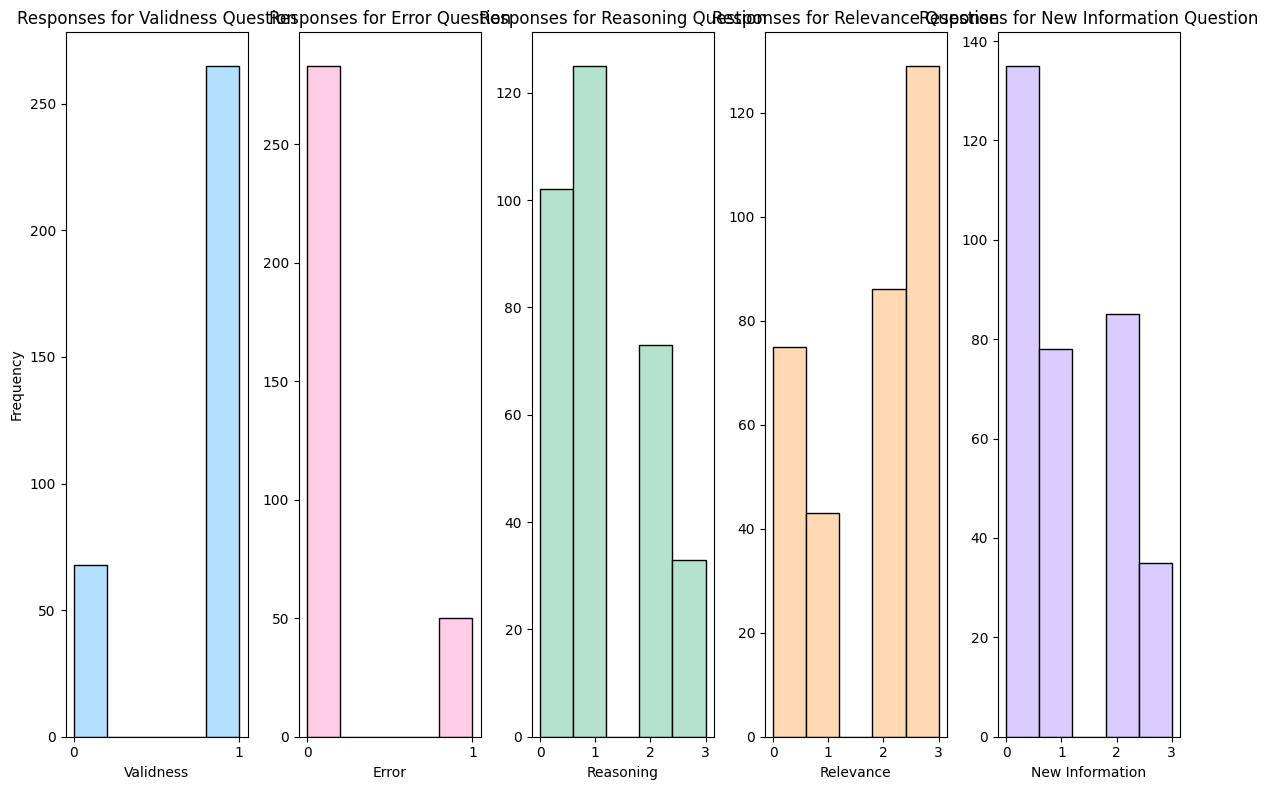

In [32]:

# Histogram of each questions
# Create separate histograms for each column
df = df_converted.copy()
plt.figure(figsize=(12, 8))
colors = ['#B3E0FF', '#FFCCE5', '#B3E2CD', '#FFD9B3', '#D9CCFF']

plt.subplot(1, 5, 1)
plt.hist(df['validness'], bins=5, edgecolor='black', color=colors[0])
plt.title('Responses for Validness Question')
plt.xlabel('Validness')
plt.ylabel('Frequency')
plt.xticks(np.arange(int(df['validness'].min()), int(df['validness'].max()) + 1, 1))

plt.subplot(1, 5, 2)
plt.hist(df['error'], bins=5, edgecolor='black', color=colors[1])
plt.title('Responses for Error Question')
plt.xlabel('Error')
plt.xticks(np.arange(int(df['error'].min()), int(df['error'].max()) + 1, 1))

plt.subplot(1, 5, 3)
plt.hist(df['reasoning'], bins=5, edgecolor='black', color=colors[2])
plt.title('Responses for Reasoning Question')
plt.xlabel('Reasoning')
plt.xticks(np.arange(int(df['reasoning'].min()), int(df['reasoning'].max()) + 1, 1))

plt.subplot(1, 5, 4)
plt.hist(df['relevance'], bins=5, edgecolor='black', color=colors[3])
plt.title('Responses for Relevance Question')
plt.xlabel('Relevance')
plt.xticks(np.arange(int(df['relevance'].min()), int(df['relevance'].max()) + 1, 1))

plt.subplot(1, 5, 5)
plt.hist(df['newInformation'], bins=5, edgecolor='black', color=colors[4])
plt.title('Responses for New Information Question')
plt.xlabel('New Information')
plt.xticks(np.arange(int(df['newInformation'].min()), int(df['newInformation'].max()) + 1, 1))

plt.tight_layout()
plt.show()

In [86]:
### For Mode 3, just use the values in df as these only contain 'valid' follow-up questions
df

,group,prefix,error,reasoning,relevance,validness,newInformation
43,full_5,3040_1,0,3,3,1,3
44,full_5,3040_2,1,2,2,1,3
45,full_5,3040_3,0,2,3,1,2
46,full_5,3041_1,0,1,2,1,2
47,full_5,3041_2,0,2,3,1,2
...,...,...,...,...,...,...,...
369,org_10,3099_1,0,3,3,1,3
372,org_10,3099_4,0,3,2,1,2
373,org_10,3099_5,0,3,2,1,3
374,org_10,3099_6,0,3,2,1,3


In [ ]:
# Mode 3 Helper Function - to retrieve only the 'valid' follow-up questions from Mode 2 from the original dataset to be used in Mode 3

